In [5]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
# --- Cell 1: Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- Cell 2: Point to your dataset inside Drive ---
import os

base_dir = "/content/drive/MyDrive/Images/Images"

appendicitis_path = os.path.join(base_dir, "Appendicitis_Images")
no_appendicitis_path = os.path.join(base_dir, "No_Appendicitis_Images")

# --- Quick sanity checks ---
print("Appendicitis path:", appendicitis_path, "| exists:", os.path.isdir(appendicitis_path))
print("No Appendicitis path:", no_appendicitis_path, "| exists:", os.path.isdir(no_appendicitis_path))

def count_images(p):
    if not os.path.isdir(p):
        return 0
    exts = (".bmp", ".jpg", ".jpeg", ".png")
    return sum(f.lower().endswith(exts) for f in os.listdir(p))

print("Found appendicitis images:", count_images(appendicitis_path))
print("Found no-appendicitis images:", count_images(no_appendicitis_path))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Appendicitis path: /content/drive/MyDrive/Images/Images/Appendicitis_Images | exists: True
No Appendicitis path: /content/drive/MyDrive/Images/Images/No_Appendicitis_Images | exists: True
Found appendicitis images: 1339
Found no-appendicitis images: 382


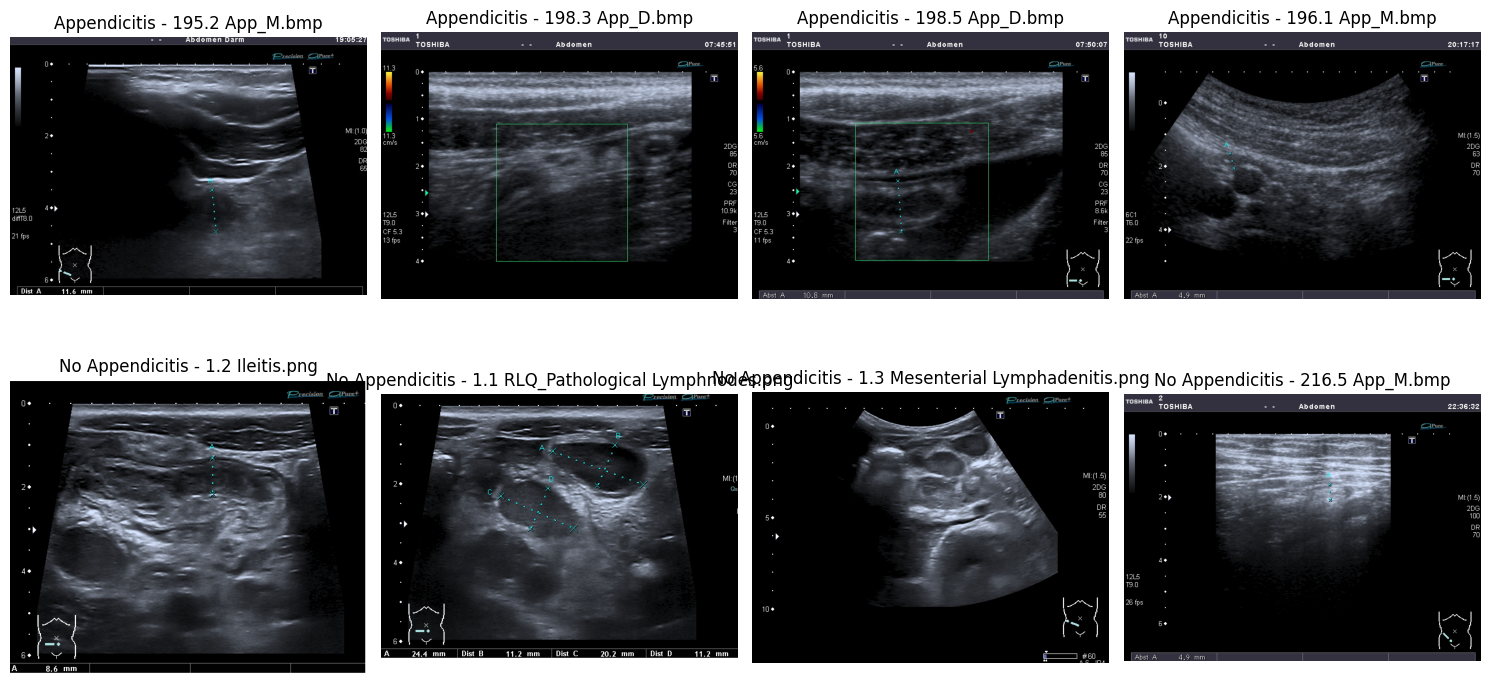

In [7]:
def plot_sample_images(num_samples=4):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 8))

    # Plot appendicitis samples
    appendicitis_files = [f for f in os.listdir(appendicitis_path)
                         if f.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png'))]
    for i in range(min(num_samples, len(appendicitis_files))):
        img_path = os.path.join(appendicitis_path, appendicitis_files[i])
        img = Image.open(img_path)
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(f'Appendicitis - {appendicitis_files[i]}')
        axes[0, i].axis('off')

    # Plot no appendicitis samples
    no_appendicitis_files = [f for f in os.listdir(no_appendicitis_path)
                            if f.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png'))]
    for i in range(min(num_samples, len(no_appendicitis_files))):
        img_path = os.path.join(no_appendicitis_path, no_appendicitis_files[i])
        img = Image.open(img_path)
        axes[1, i].imshow(img, cmap='gray')
        axes[1, i].set_title(f'No Appendicitis - {no_appendicitis_files[i]}')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

plot_sample_images()

In [8]:
def load_and_preprocess_data(img_size=(224, 224)):
    """
    Load and preprocess images from both categories
    """
    images = []
    labels = []

    # Load appendicitis images (label = 1)
    print("Loading appendicitis images...")
    appendicitis_files = [f for f in os.listdir(appendicitis_path)
                         if f.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png'))]

    for filename in appendicitis_files:
        try:
            img_path = os.path.join(appendicitis_path, filename)
            img = Image.open(img_path)

            # Convert to RGB if needed
            if img.mode != 'RGB':
                img = img.convert('RGB')

            # Resize image
            img = img.resize(img_size)
            img_array = np.array(img) / 255.0  # Normalize to [0,1]

            images.append(img_array)
            labels.append(1)  # Appendicitis

        except Exception as e:
            print(f"Error loading {filename}: {e}")

    # Load no appendicitis images (label = 0)
    print("Loading no appendicitis images...")
    no_appendicitis_files = [f for f in os.listdir(no_appendicitis_path)
                            if f.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png'))]

    for filename in no_appendicitis_files:
        try:
            img_path = os.path.join(no_appendicitis_path, filename)
            img = Image.open(img_path)

            # Convert to RGB if needed
            if img.mode != 'RGB':
                img = img.convert('RGB')

            # Resize image
            img = img.resize(img_size)
            img_array = np.array(img) / 255.0  # Normalize to [0,1]

            images.append(img_array)
            labels.append(0)  # No appendicitis

        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(images), np.array(labels)

# Load the data
X, y = load_and_preprocess_data()
print(f"Loaded {len(X)} images with shape: {X.shape}")
print(f"Labels distribution: {np.bincount(y)}")

Loading appendicitis images...
Loading no appendicitis images...
Loaded 1721 images with shape: (1721, 224, 224, 3)
Labels distribution: [ 382 1339]


In [9]:
# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")

# Check class distribution
print("\nClass distribution:")
print(f"Train - Appendicitis: {np.sum(y_train)}, No appendicitis: {len(y_train) - np.sum(y_train)}")
print(f"Val - Appendicitis: {np.sum(y_val)}, No appendicitis: {len(y_val) - np.sum(y_val)}")
print(f"Test - Appendicitis: {np.sum(y_test)}, No appendicitis: {len(y_test) - np.sum(y_test)}")

Training set: 1204 images
Validation set: 258 images
Test set: 259 images

Class distribution:
Train - Appendicitis: 937, No appendicitis: 267
Val - Appendicitis: 201, No appendicitis: 57
Test - Appendicitis: 201, No appendicitis: 58


In [10]:
# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

# No augmentation for validation and test sets
val_test_datagen = ImageDataGenerator()

# Calculate class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

print("Class weights:", class_weight_dict)
print(f"Weight for no appendicitis (class 0): {class_weight_dict[0]:.2f}")
print(f"Weight for appendicitis (class 1): {class_weight_dict[1]:.2f}")

Class weights: {0: np.float64(2.254681647940075), 1: np.float64(0.6424759871931697)}
Weight for no appendicitis (class 0): 2.25
Weight for appendicitis (class 1): 0.64


In [11]:
from tensorflow.keras.applications import DenseNet201  # changed from DenseNet121

def create_densenet_model(input_shape=(224, 224, 3), num_classes=1):
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)  # changed
    base_model.trainable = False

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

model = create_densenet_model()
model.summary()




74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1920)           │         7,680 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       983,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,444,801 (74.18 MB)

 Trainable params: 1,118,977 (4.27 MB)

 Non-trainable params: 18,325,824 (69.91 MB)

In [12]:
import tensorflow.keras.backend as K

def f1_score(y_true, y_pred):
    """Custom F1 score metric"""
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    return 2*((precision_val*recall_val)/(precision_val+recall_val+K.epsilon()))

# Then recompile with this custom metric:
from keras.metrics import F1Score  # Keras 3

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        F1Score(name="f1", threshold=0.5, average="micro")
    ],
)


In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Create callbacks (updated to monitor val_accuracy instead of val_f1_score)
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_appendicitis_model_oversampling.keras',
        monitor='val_accuracy',  # Changed from val_f1_score
        mode='max',
        save_best_only=True,
        verbose=1
    )
]

print("Callbacks configured!")

Callbacks configured!


In [14]:
# Convert labels to float32 to avoid dtype issues
y_train_float = y_train.astype(np.float32).reshape(-1, 1)
y_val_float   = y_val.astype(np.float32).reshape(-1, 1)

# First phase: Train only the top layers
print("Starting Phase 1: Training custom layers only...")
print(f"Base model trainable: {model.layers[0].trainable}")

history_phase1 = model.fit(
    train_datagen.flow(X_train, y_train_float, batch_size=32),
    epochs=20,
    validation_data=(X_val, y_val_float),
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

print("Phase 1 training completed!")

Starting Phase 1: Training custom layers only...
Base model trainable: False


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6297 - f1: 0.7264 - loss: 0.7884 - precision: 0.8336 - recall: 0.6448
Epoch 1: val_accuracy improved from -inf to 0.56202, saving model to best_appendicitis_model_oversampling.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.6292 - f1: 0.7261 - loss: 0.7889 - precision: 0.8335 - recall: 0.6442 - val_accuracy: 0.5620 - val_f1: 0.6413 - val_loss: 0.6714 - val_precision: 0.8860 - val_recall: 0.5025 - learning_rate: 0.0010
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.6360 - f1: 0.7250 - loss: 0.6735 - precision: 0.8906 - recall: 0.6134
Epoch 2: val_accuracy improved from 0.56202 to 0.60078, saving model to best_appendicitis_model_oversampling.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 448ms/step - accuracy: 0.6359 - f1: 0.7251 - loss: 0.6746 - precision: 0.8896 - recall: 0.6140 - val_accuracy: 0.6008 - val_f1: 0.6850 - val_loss: 0.6457 - val_precision: 0.8889 - val_recall: 0.5572 - learning_rate: 0.001

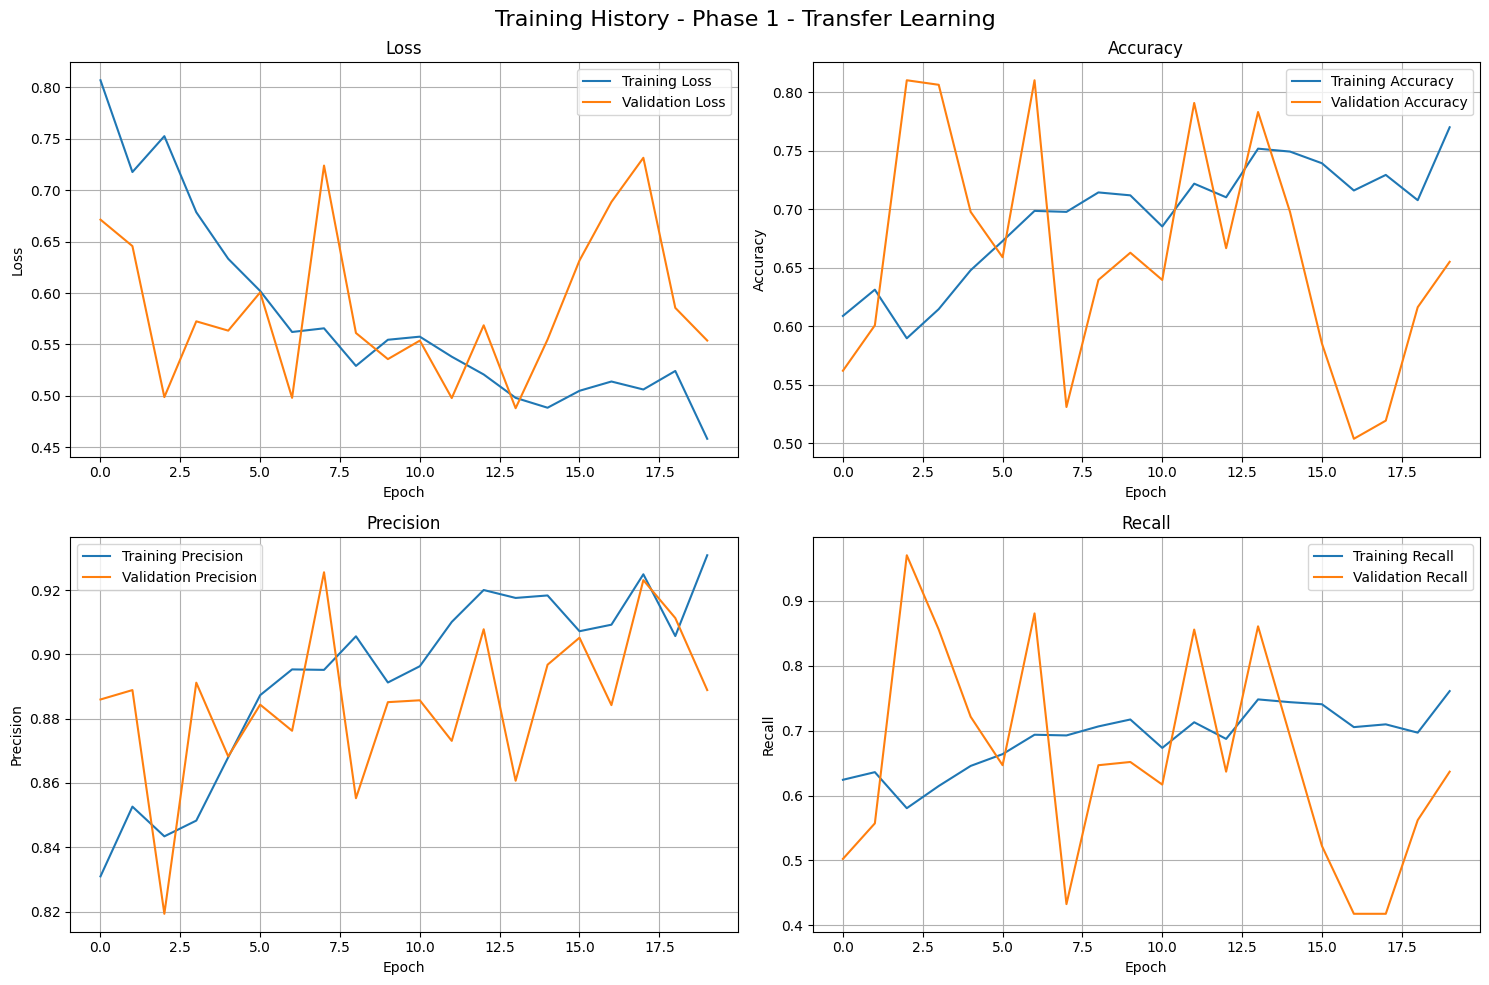

In [15]:
def plot_training_history(history, phase_name=""):
    """
    Plot training and validation metrics
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Training History - {phase_name}', fontsize=16)

    # Plot loss
    axes[0, 0].plot(history.history['loss'], label='Training Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Plot accuracy
    axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 1].set_title('Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Plot precision
    axes[1, 0].plot(history.history['precision'], label='Training Precision')
    axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
    axes[1, 0].set_title('Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Plot recall
    axes[1, 1].plot(history.history['recall'], label='Training Recall')
    axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
    axes[1, 1].set_title('Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

# Plot Phase 1 results
plot_training_history(history_phase1, "Phase 1 - Transfer Learning")

Phase 1 - Validation Set Evaluation:
9/9 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step

Classification Report:
                 precision    recall  f1-score   support

No Appendicitis       0.36      0.72      0.48        57
   Appendicitis       0.89      0.64      0.74       201

       accuracy                           0.66       258
      macro avg       0.62      0.68      0.61       258
   weighted avg       0.77      0.66      0.68       258



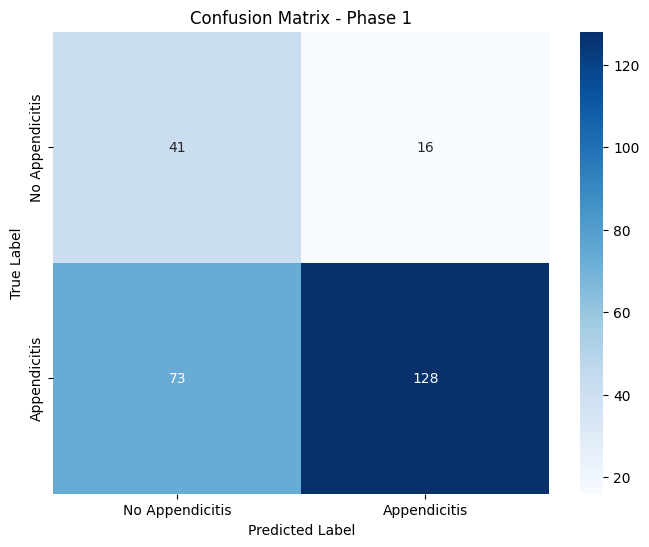


Sensitivity (Recall): 0.637
Specificity: 0.719


In [16]:
# Evaluate on validation set
print("Phase 1 - Validation Set Evaluation:")
val_predictions = model.predict(X_val)
val_predictions_binary = (val_predictions > 0.5).astype(int).ravel()

print("\nClassification Report:")
print(classification_report(y_val.ravel(), val_predictions_binary,
                          target_names=['No Appendicitis', 'Appendicitis']))

# Confusion Matrix
cm = confusion_matrix(y_val.ravel(), val_predictions_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Appendicitis', 'Appendicitis'],
            yticklabels=['No Appendicitis', 'Appendicitis'])
plt.title('Confusion Matrix - Phase 1')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print some metrics
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f"\nSensitivity (Recall): {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")

In [17]:
# Unfreeze the tail of DenseNet for fine-tuning
base_model = model.layers[0]
for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

print("Fine-tuning setup:")
print(f"Total layers in base model: {len(base_model.layers)}")
print(f"Trainable layers: {sum(1 for layer in base_model.layers if layer.trainable)}")

# LOWER LR for fine-tuning and keep F1 metric
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        F1Score(name='f1', threshold=0.5, average='micro'),
    ]
)

print("Model recompiled for fine-tuning!")

Fine-tuning setup:
Total layers in base model: 707
Trainable layers: 4
Model recompiled for fine-tuning!


In [18]:
# Reset callbacks for phase 2
callbacks_phase2 = [

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-8,
        verbose=1
    ),
    ModelCheckpoint(
        'best_appendicitis_model_phase2_oversampling.keras',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )
]

print("Starting Phase 2: Fine-tuning...")

history_phase2 = model.fit(
    train_datagen.flow(X_train, y_train_float, batch_size=16),  # Smaller batch size
    epochs=15,  # Fewer epochs for fine-tuning
    validation_data=(X_val, y_val_float),
    class_weight=class_weight_dict,
    callbacks=callbacks_phase2,
    verbose=1
)

print("Phase 2 training completed!")

Starting Phase 2: Fine-tuning...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.7696 - f1: 0.8428 - loss: 0.4821 - precision: 0.9047 - recall: 0.7893
Epoch 1: val_accuracy improved from -inf to 0.55426, saving model to best_appendicitis_model_phase2_oversampling.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.7695 - f1: 0.8428 - loss: 0.4819 - precision: 0.9048 - recall: 0.7892 - val_accuracy: 0.5543 - val_f1: 0.6254 - val_loss: 0.6167 - val_precision: 0.9057 - val_recall: 0.4776 - learning_rate: 1.0000e-04
Epoch 2/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.7598 - f1: 0.8299 - loss: 0.4658 - precision: 0.9343 - recall: 0.7469
Epoch 2: val_accuracy did not improve from 0.55426
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 211ms/step - accuracy: 0.7599 - f1: 0.8300 - loss: 0.4657 - precision: 0.9342 - recall: 0.7471 - val_accuracy: 0.5504 - val_f1: 0.6133 - val_loss: 0.6202 - val_precision: 0.9293 - val_recall: 0.4577 - learning_rate: 1.0000e-04
Epoch 3/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 202

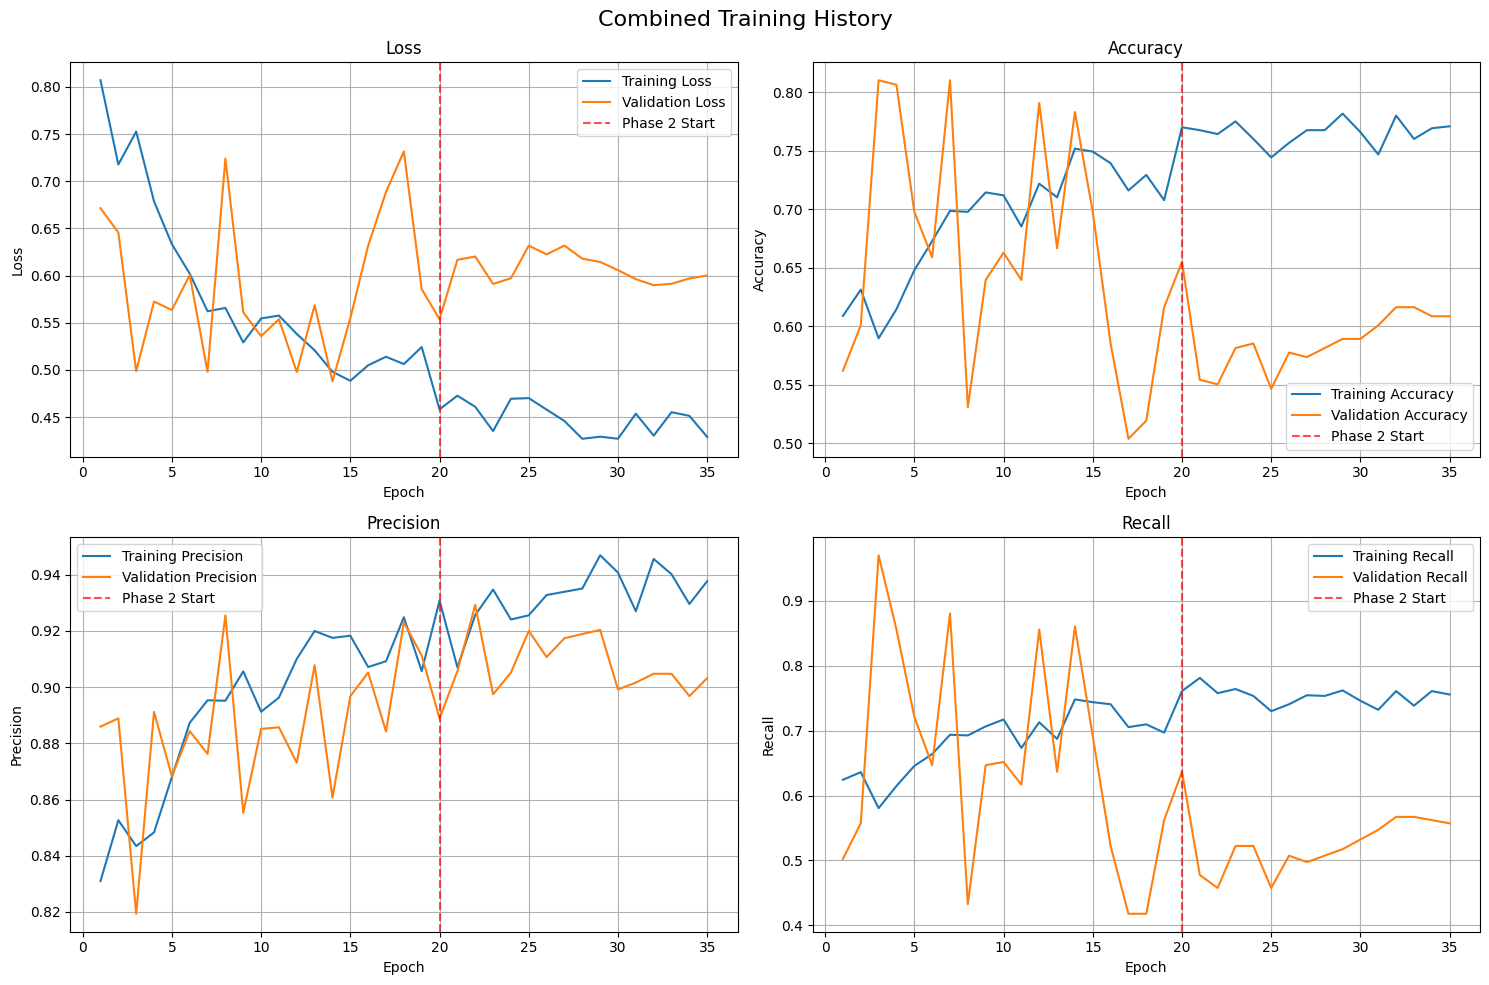

In [19]:
def plot_combined_history(hist1, hist2, phase1_name="Phase 1", phase2_name="Phase 2"):
    """
    Plot combined training history from both phases
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Combined Training History', fontsize=16)

    # Combine histories
    phase1_epochs = len(hist1.history['loss'])
    total_epochs = range(1, phase1_epochs + len(hist2.history['loss']) + 1)
    combined_loss = hist1.history['loss'] + hist2.history['loss']
    combined_val_loss = hist1.history['val_loss'] + hist2.history['val_loss']
    combined_acc = hist1.history['accuracy'] + hist2.history['accuracy']
    combined_val_acc = hist1.history['val_accuracy'] + hist2.history['val_accuracy']

    # Plot loss
    axes[0, 0].plot(total_epochs, combined_loss, label='Training Loss')
    axes[0, 0].plot(total_epochs, combined_val_loss, label='Validation Loss')
    axes[0, 0].axvline(x=phase1_epochs, color='red', linestyle='--', alpha=0.7, label='Phase 2 Start')
    axes[0, 0].set_title('Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Plot accuracy
    axes[0, 1].plot(total_epochs, combined_acc, label='Training Accuracy')
    axes[0, 1].plot(total_epochs, combined_val_acc, label='Validation Accuracy')
    axes[0, 1].axvline(x=phase1_epochs, color='red', linestyle='--', alpha=0.7, label='Phase 2 Start')
    axes[0, 1].set_title('Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Plot precision
    combined_precision = hist1.history['precision'] + hist2.history['precision']
    combined_val_precision = hist1.history['val_precision'] + hist2.history['val_precision']
    axes[1, 0].plot(total_epochs, combined_precision, label='Training Precision')
    axes[1, 0].plot(total_epochs, combined_val_precision, label='Validation Precision')
    axes[1, 0].axvline(x=phase1_epochs, color='red', linestyle='--', alpha=0.7, label='Phase 2 Start')
    axes[1, 0].set_title('Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Plot recall
    combined_recall = hist1.history['recall'] + hist2.history['recall']
    combined_val_recall = hist1.history['val_recall'] + hist2.history['val_recall']
    axes[1, 1].plot(total_epochs, combined_recall, label='Training Recall')
    axes[1, 1].plot(total_epochs, combined_val_recall, label='Validation Recall')
    axes[1, 1].axvline(x=phase1_epochs, color='red', linestyle='--', alpha=0.7, label='Phase 2 Start')
    axes[1, 1].set_title('Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

# Plot combined results
plot_combined_history(history_phase1, history_phase2)

Final Evaluation on Test Set:
Test Loss: 0.7269
Test Accuracy: 0.5753
Test Precision: 0.8640
Test Recall: 0.5373
Test F1: 0.6626

Final Test Set Classification Report:
                 precision    recall  f1-score   support

No Appendicitis       0.31      0.71      0.43        58
   Appendicitis       0.86      0.54      0.66       201

       accuracy                           0.58       259
      macro avg       0.58      0.62      0.54       259
   weighted avg       0.74      0.58      0.61       259



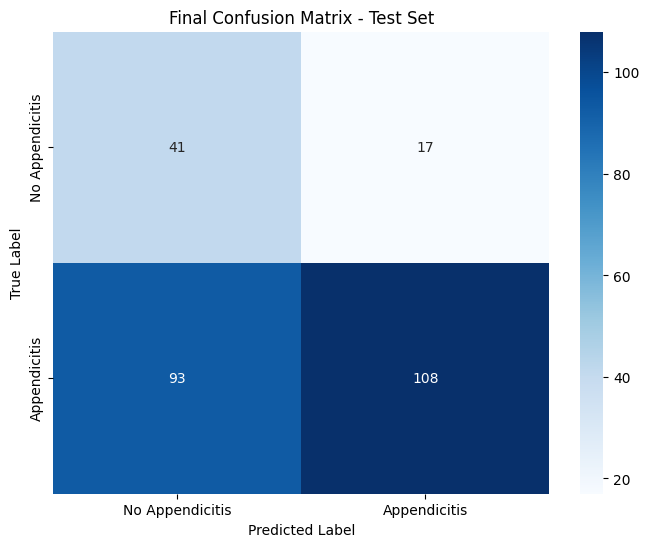


Final Test Metrics:
Sensitivity (Recall): 0.537
Specificity: 0.707
F1-Score: 0.663
Balanced Accuracy: 0.622


In [20]:
# Convert test labels to float32 (2D for Keras 3 F1)
y_test_float = y_test.astype(np.float32).reshape(-1, 1)

print("Final Evaluation on Test Set:")
test_loss, test_acc, test_precision, test_recall, test_f1 = model.evaluate(X_test, y_test_float, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1: {test_f1:.4f}")

# Predictions → 1D for sklearn
test_predictions = model.predict(X_test, verbose=0)
test_predictions_binary = (test_predictions > 0.5).astype(int).ravel()

from sklearn.metrics import classification_report, confusion_matrix, f1_score

print("\nFinal Test Set Classification Report:")
print(classification_report(y_test.ravel(), test_predictions_binary,
                            target_names=['No Appendicitis', 'Appendicitis']))

cm_test = confusion_matrix(y_test.ravel(), test_predictions_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Appendicitis', 'Appendicitis'],
            yticklabels=['No Appendicitis', 'Appendicitis'])
plt.title('Final Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

tn, fp, fn, tp = cm_test.ravel()
final_sensitivity = tp / (tp + fn)
final_specificity = tn / (tn + fp)

# Use sklearn F1 on hard predictions (more accurate than 2*P*R/(P+R) from averaged metrics)
final_f1 = f1_score(y_test.ravel(), test_predictions_binary)

print(f"\nFinal Test Metrics:")
print(f"Sensitivity (Recall): {final_sensitivity:.3f}")
print(f"Specificity: {final_specificity:.3f}")
print(f"F1-Score: {final_f1:.3f}")
print(f"Balanced Accuracy: {(final_sensitivity + final_specificity) / 2:.3f}")





Additional Evaluation Metrics:
Macro F1 Score: 0.5448
AUC (ROC): 0.6591


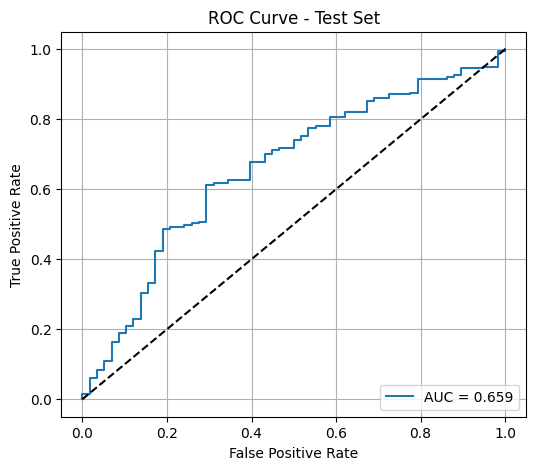

In [21]:
# === Additional Metrics: Macro F1 and AUC ===
from sklearn.metrics import f1_score, roc_auc_score, roc_curve

# Compute Macro-F1 (averages F1 equally across both classes)
macro_f1 = f1_score(y_test, test_predictions_binary, average='macro')

# Compute AUC using probability predictions (not binary)
auc = roc_auc_score(y_test, test_predictions)

print("\nAdditional Evaluation Metrics:")
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"AUC (ROC): {auc:.4f}")

# --- Optional visualization of ROC Curve ---
fpr, tpr, thresholds = roc_curve(y_test, test_predictions)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [22]:
# Save the complete model
model.save('final_appendicitis_densenet201_oversampling.keras')
print("Model saved as 'final_appendicitis_densenet201_oversampling.keras'")

# Save model architecture as JSON
model_json = model.to_json()
with open("appendicitis_model_architecture_oversampling.json", "w") as json_file:
    json_file.write(model_json)

# Save only the weights
model.save_weights("appendicitis_model_weights_oversampling.weights.h5")
print("Model architecture and weights saved separately")

Model saved as 'final_appendicitis_densenet201_oversampling.keras'
Model architecture and weights saved separately


In [26]:
import os, shutil

# Create a permanent backup folder in your Drive
save_dir = "/content/drive/MyDrive/Appendicitis_Models"
os.makedirs(save_dir, exist_ok=True)

# Copy all your key files into Drive
for f in [
    "final_appendicitis_densenet201_oversampling.keras",
    "best_appendicitis_model_phase2_oversampling.keras",
    "appendicitis_model_weights_oversampling.weights.h5",
    "appendicitis_model_architecture_oversampling.json"
]:
    if os.path.exists(f):
        shutil.copy(f, save_dir)
        print(f"✅ Saved: {f}")
    else:
        print(f"⚠️ File not found: {f}")

print(f"\n✅ All done! Files are now backed up to {save_dir}")


✅ Saved: final_appendicitis_densenet201_oversampling.keras
✅ Saved: best_appendicitis_model_phase2_oversampling.keras
✅ Saved: appendicitis_model_weights_oversampling.weights.h5
✅ Saved: appendicitis_model_architecture_oversampling.json

✅ All done! Files are now backed up to /content/drive/MyDrive/Appendicitis_Models


In [27]:
!ls -lh /content/drive/MyDrive/Appendicitis_Models


total 257M
-rw------- 1 root root 638K Oct  7 15:28 appendicitis_model_architecture_oversampling.json
-rw------- 1 root root  85M Oct  7 15:28 appendicitis_model_weights_oversampling.weights.h5
-rw------- 1 root root  86M Oct  7 15:28 best_appendicitis_model_phase2_oversampling.keras
-rw------- 1 root root  86M Oct  7 15:28 final_appendicitis_densenet201_oversampling.keras


In [23]:
def predict_appendicitis(image_path, model_path, threshold=0.5):
    """
    Predict appendicitis for a new ultrasound image

    Args:
        image_path: Path to the image file
        model_path: Path to the saved model file (.h5 or .keras)
        threshold: Decision threshold (default 0.5)

    Returns:
        Dictionary with prediction results
    """
    try:
        # Load the model from file
        loaded_model = tf.keras.models.load_model(model_path)

        # Load and preprocess image
        img = Image.open(image_path)

        # Convert to RGB if needed
        if img.mode != 'RGB':
            img = img.convert('RGB')

        # Resize to model input size
        img = img.resize((224, 224))
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make prediction
        prediction_prob = loaded_model.predict(img_array, verbose=0)[0][0]
        prediction_binary = int(prediction_prob > threshold)

        # Prepare result
        result = {
            'image_path': image_path,
            'probability': float(prediction_prob),
            'prediction': 'Appendicitis' if prediction_binary == 1 else 'No Appendicitis',
            'confidence': float(max(prediction_prob, 1 - prediction_prob)),
            'threshold_used': threshold
        }

        return result

    except Exception as e:
        return {'error': str(e), 'image_path': image_path}

In [24]:
# Create a simple deployment script
deployment_code = '''
import numpy as np
from PIL import Image
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model('final_appendicitis_densenet201_oversampling.keras')

def predict_single_image(image_path, threshold=0.5):
    img = Image.open(image_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction_prob = model.predict(img_array, verbose=0)[0][0]
    prediction = "Appendicitis" if prediction_prob > threshold else "No Appendicitis"
    confidence = max(prediction_prob, 1 - prediction_prob)

    return {
        'prediction': prediction,
        'probability': float(prediction_prob),
        'confidence': float(confidence)
    }
'''


with open('deploy_model.py', 'w') as f:
    f.write(deployment_code)

print("Deployment script created as 'deploy_model.py'")

Deployment script created as 'deploy_model.py'


In [25]:
result = predict_appendicitis(
    "processed_data/doesnt_have_appendicitis/352.2 App_D.bmp",
    "final_appendicitis_densenet201_oversampling.keras"
)
print("Prediction result:", result)


Prediction result: {'error': "[Errno 2] No such file or directory: 'processed_data/doesnt_have_appendicitis/352.2 App_D.bmp'", 'image_path': 'processed_data/doesnt_have_appendicitis/352.2 App_D.bmp'}
